# Resampling Research Notebook 

## Trying to improve |Set_N| using theory or practical observations

***
Imporrting packages 
***

In [59]:
import numpy as np              
import pandas as pd              

import scipy.stats as stats      

from sklearn.neighbors import NearestNeighbors  
from sklearn.neighbors import KDTree            
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import BaggingClassifier   
from sklearn.ensemble import AdaBoostClassifier  

from sklearn.metrics import roc_auc_score        
from sklearn.metrics import recall_score         
from sklearn.metrics import f1_score             
from sklearn.metrics import confusion_matrix     
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE 
from imblearn.combine import SMOTETomek, SMOTEENN 

from sklearn.datasets import fetch_openml
from sklearn.datasets import make_classification

import matplotlib.pyplot as plt
import seaborn as sns

***
Downloading and Processing UCI Datasets
***

In [74]:
# there might be a problem with dealing with categorical variables  
# computations considers distance 
# if the variable is one-hot-encoded then it might cause problems 

def get_processed_uci_datasets():
    datasets = {}

    # 1. Abalone (No. 1) - abalone9-18
    print("Fetching Abalone...")
    X, y = fetch_openml(name='abalone', version=1, return_X_y=True, as_frame=True)
    df = pd.concat([X, y], axis=1)
    df = df[df['Class_number_of_rings'].isin(['9', '18'])].copy()
    # Map: 18 -> +1, 9 -> -1
    target = np.where(df['Class_number_of_rings'] == '18', 1, -1)
    #X_final = pd.get_dummies(df.drop(columns=['Class_number_of_rings']), columns=['Sex'], drop_first=True)
    X_final = df.drop(columns=['Class_number_of_rings', 'Sex'])
    datasets['abalone9-18'] = (X_final, pd.Series(target, name='target'))

    # 5. Ecoli (No. 5) - ecoli-0-1-4-7_vs_5-6
    print("Fetching Ecoli...")
    X, y = fetch_openml(name='ecoli', version=1, return_X_y=True, as_frame=True)
    y = y.astype(str).str.strip()
    minority_labels = ['omL', 'imL']          # Classes 5, 6
    majority_labels = ['cp', 'im', 'om', 'imS'] # Classes 0, 1, 4, 7
    relevant_labels = minority_labels + majority_labels
    mask = y.isin(relevant_labels)
    X_ecoli = X[mask].copy()
    y_ecoli = y[mask].copy()
    # Map: omL/imL -> +1, Others -> -1
    target = np.where(y_ecoli.isin(minority_labels), 1, -1)
    X_ecoli = X_ecoli.drop(columns=['Sequence_Name'], errors='ignore')
    datasets['ecoli-0147vs56'] = (X_ecoli, pd.Series(target, name='target'))

    # 3. Haberman (No. 15)
    print("Fetching Haberman...")
    X, y = fetch_openml(name='haberman', version=1, return_X_y=True, as_frame=True)
    y = y.astype(int)
    # Map: 2 (Died) -> +1, 1 (Survived) -> -1
    target = np.where(y == 2, 1, -1)
    datasets['haberman'] = (X, pd.Series(target, name='target'))

    # 4. Yeast (No. 27) - yeast-1vs7
    print("Fetching Yeast...")
    X, y = fetch_openml(name='yeast', version=1, return_X_y=True, as_frame=True)
    y = y.astype(str).str.strip()
    mask = y.isin(['VAC', 'NUC'])
    X_yeast = X[mask].copy()
    y_yeast = y[mask].copy()
    # Map: VAC -> +1, NUC -> -1
    target = np.where(y_yeast == 'VAC', 1, -1)
    cols_to_drop = ['Sequence_Name']
    X_yeast = X_yeast.drop(columns=cols_to_drop, errors='ignore')
    datasets['yeast-1vs7'] = (X_yeast, pd.Series(target, name='target'))

    # returning fromat : dictionary of (X, y)
    return datasets

***
Function for creating own datasets with various types and number of variables  
***

In [61]:
def create_synthetic_overlap(n_samples=1000, n_features=2, weights=(0.9, 0.1), density_type='high'):
    """
    Creates binary dataset with specific overlap characteristics.
    Minority = +1, Majority = -1
    """
    rng = np.random.RandomState(42)
    n_min = int(n_samples * weights[1])
    n_maj = n_samples - n_min
    
    # Generate Minority Class (centered at 0)
    X_min = rng.normal(loc=0.0, scale=1.0, size=(n_min, n_features))
    y_min = np.ones(n_min)
    
    # Generate Majority Class based on density type
    if density_type == 'high':
        # Type 1: High density in overlap
        # Mean close to 0, standard deviation same as minority to ensure dense overlap
        X_maj = rng.normal(loc=1.0, scale=1.0, size=(n_maj, n_features))
        
    elif density_type == 'sparse':
        # Type 2: Overlap exists but majority is sparse there
        # Bimodal majority: Main cluster far away, small cluster overlapping
        n_maj_overlap = int(n_maj * 0.1) # Only 10% in overlap
        n_maj_far = n_maj - n_maj_overlap
        
        X_maj_overlap = rng.normal(loc=0.0, scale=1.0, size=(n_maj_overlap, n_features))
        X_maj_far = rng.normal(loc=5.0, scale=1.0, size=(n_maj_far, n_features))
        X_maj = np.vstack([X_maj_overlap, X_maj_far])
        
    y_maj = -1 * np.ones(n_maj)
    
    X = np.vstack([X_min, X_maj])
    y = np.hstack([y_min, y_maj])
    
    feat_names = [f"feat_{i}" for i in range(n_features)]

    # returning fromat : (X, y)
    return (X, pd.Series(y, name='target'))

***
Downloading and Creating datasets 
***

In [62]:
uci_datasets = get_processed_uci_datasets()

synthetic_datasets = {}

synthetic_datasets['synth_type1_1d_v1'] = create_synthetic_overlap(n_features=1, weights=(0.9, 0.1), density_type='high')
synthetic_datasets['synth_type1_1d_v2'] = create_synthetic_overlap(n_features=1, weights=(0.94, 0.06), density_type='high')

synthetic_datasets['synth_type1_2d_v1'] = create_synthetic_overlap(n_features=2, weights=(0.81, 0.19), density_type='high')
synthetic_datasets['synth_type1_2d_v2'] = create_synthetic_overlap(n_features=2, weights=(0.9, 0.1), density_type='high')

synthetic_datasets['synth_type1_3d_v1'] = create_synthetic_overlap(n_features=3, weights=(0.75, 0.25), density_type='high')
synthetic_datasets['synth_type1_3d_v2'] = create_synthetic_overlap(n_features=3, weights=(0.95, 0.05), density_type='high')

synthetic_datasets['synth_type2_2d_example'] = create_synthetic_overlap(n_features=2, density_type='sparse')

datasets = {}

for key, values in uci_datasets.items():
    datasets[key] = values
for key, values in synthetic_datasets.items():
    datasets[key] = values

Fetching Abalone...
Fetching Ecoli...
Fetching Haberman...
Fetching Yeast...


***
Getting information
***

In [63]:
print("\n--- UCI Datasets Loaded ---")
for name, (X, y) in uci_datasets.items():
    print(f"{name}: Features={X.shape[1]}, Samples={len(y)}, Ratio (Maj/Min)={y.value_counts()[-1]/y.value_counts()[1]:.2f}")

print("\n--- Synthetic Datasets Created ---")
for name, (X, y) in synthetic_datasets.items():
    print(f"{name}: Features={X.shape[1]}, Samples={len(y)}, Ratio (Maj/Min)={y.value_counts()[-1]/y.value_counts()[1]:.2f}")


--- UCI Datasets Loaded ---
abalone9-18: Features=7, Samples=731, Ratio (Maj/Min)=16.40
ecoli-0147vs56: Features=7, Samples=249, Ratio (Maj/Min)=34.57
haberman: Features=3, Samples=306, Ratio (Maj/Min)=2.78
yeast-1vs7: Features=8, Samples=459, Ratio (Maj/Min)=14.30

--- Synthetic Datasets Created ---
synth_type1_1d_v1: Features=1, Samples=1000, Ratio (Maj/Min)=9.00
synth_type1_1d_v2: Features=1, Samples=1000, Ratio (Maj/Min)=15.67
synth_type1_2d_v1: Features=2, Samples=1000, Ratio (Maj/Min)=4.26
synth_type1_2d_v2: Features=2, Samples=1000, Ratio (Maj/Min)=9.00
synth_type1_3d_v1: Features=3, Samples=1000, Ratio (Maj/Min)=3.00
synth_type1_3d_v2: Features=3, Samples=1000, Ratio (Maj/Min)=19.00
synth_type2_2d_example: Features=2, Samples=1000, Ratio (Maj/Min)=9.00


***
Functions for getting complexity of the dataset
***

In [64]:
def calculate_complexity(X, y, k=5):
    """
    Calculates Maj_Com and Min_Com based on Eq. 15.
    Metric: Average proportion of k-nearest neighbors belonging to the same class.
    """
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
        
    X_encoded = pd.get_dummies(X, drop_first=True)
    X_encoded = X_encoded.astype(float)
    X_norm = (X_encoded - X_encoded.mean()) / X_encoded.std()
    X_norm = X_norm.fillna(0) 
    
    knn = NearestNeighbors(n_neighbors=k+1).fit(X_norm) # +1 because sample includes itself

    def get_class_complexity(target_class):
        class_indices = np.where(y == target_class)[0]
        if len(class_indices) == 0: return 0.0
        distances, indices = knn.kneighbors(X_norm.iloc[class_indices])
        
        neighbor_indices = indices[:, 1:]
        neighbor_labels = y.iloc[neighbor_indices.flatten()].values.reshape(neighbor_indices.shape)
        matches = (neighbor_labels == target_class).astype(int)
    
        return np.mean(np.mean(matches, axis=1))

    maj_com = get_class_complexity(-1)
    min_com = get_class_complexity(1)
    
    return maj_com, min_com

***
Function for getting comprasion between complexities of the min and maj class
***

In [65]:
def compare_complexities(datasets):
    results = []
    names = []
    
    for name, (X, y) in datasets.items():
        maj_c, min_c = calculate_complexity(X, y)
        results.append([maj_c, min_c])
        names.append(name)
    
    df_res = pd.DataFrame(results, columns=['Maj_Com', 'Min_Com'], index=names)
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    x = np.arange(len(names))
    width = 0.35
    
    rects1 = ax.bar(x - width/2, df_res['Maj_Com'], width, label='Maj_Com', color='blue')
    rects2 = ax.bar(x + width/2, df_res['Min_Com'], width, label='Min_Com', 
                    color='white', edgecolor='red', hatch='///')
    
    ax.set_ylabel('Data Complexity Measure')
    ax.set_title('Comparison of Majority and Minority Class Complexity')
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha='right')
    ax.set_ylim(0, 1.05)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    plt.clf()

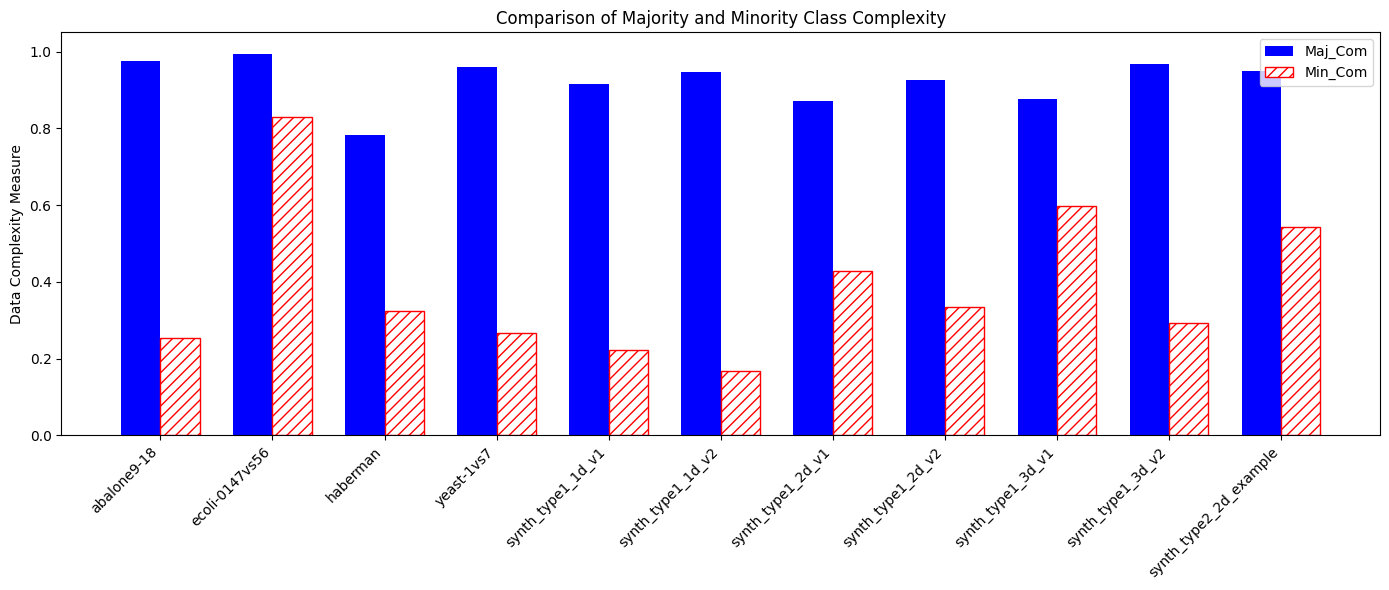

<Figure size 640x480 with 0 Axes>

In [66]:
compare_complexities(datasets)

***
Function for getting number of samples in Set_N
***

In [67]:
def calculate_set_n_size(X_maj, n_min, alpha=0.05, epsilon=0.05, M=1.5):
    """
    Calculates the size of the majority subset |Set_N| based on Eqs. 3, 4, and 5.
    
    Parameters:
    -----------
    X_maj : array-like or pd.DataFrame
        The feature matrix of the majority class samples (used to calc sigma).
    n_min : int
        Number of minority samples (|P|).
    alpha : float, optional (default=0.05)
        Significance level for the Z-test (e.g., 0.05 for 95% confidence).
    epsilon : float, optional (default=0.05)
        Acceptable tolerance error.
    M : float, optional (default=1.5)
        Imbalance Ratio threshold for the concatenated dataset.
        
    Returns:
    --------
    int
        The calculated size of |Set_N|.
    """

    n_maj = len(X_maj)
    
    n1 = (n_min ** 2) / n_maj

    if isinstance(X_maj, pd.DataFrame):
        X_vals = pd.get_dummies(X_maj, drop_first=True).astype(float).values
    else:
        try:
            X_vals = np.array(X_maj, dtype=float)
        except:
            X_vals = pd.get_dummies(pd.DataFrame(X_maj), drop_first=True).astype(float).values
        
    z_score = stats.norm.ppf(1 - alpha / 2)
    sigma = np.std(X_vals)
    z_sq = z_score ** 2
    sigma_sq = sigma ** 2
    epsilon_sq = epsilon ** 2
    numerator = n_maj * z_sq * sigma_sq # if z_sq / sigma_sq / N lower than current, could improve n2
    denominator = (n_maj * epsilon_sq) + (z_sq * sigma_sq) # if epsilon_sq higher, could improve n2 
    n2 = numerator / denominator

    if n1 == 0: 
        return int(n2)
        
    Pr = n2 / n1

    if Pr < 1:
        set_n_size = n1
    elif 1 <= Pr <= M:
        set_n_size = n2
    else: # Pr > M
        set_n_size = M * n1
        
    return int(np.ceil(set_n_size))

***
Function for sampling Set_N using ramndom wheighted choise 
***

In [68]:
def get_set_n_random_weighted(X, y, n_size, k=5):
    """
    Parameters:
    -----------
    X : pd.DataFrame or np.array
        The full training feature matrix.
    y : pd.Series or np.array
        The full training target vector (Minority=+1, Majority=-1).
    n_size : int
        The number of samples to select for Set_N (calculated previously).
    k : int, optional (default=5)
        Number of neighbors for weight calculation.

    Returns:
    --------
    X_set_n : pd.DataFrame/np.array
        The selected majority samples.
    """
    if isinstance(X, pd.DataFrame):
        X_original = X
        X_numeric = pd.get_dummies(X, drop_first=True).astype(float).values
        X_index = X.index
    else:
        X_original = X
        try:
            X_numeric = np.array(X, dtype=float)
        except:
            X_numeric = pd.get_dummies(pd.DataFrame(X), drop_first=True).astype(float).values
        X_index = np.arange(len(X))
        
        
    if isinstance(y, pd.Series):
        y_vals = y.values
    else:
        y_vals = y

    maj_mask = (y_vals == -1)
    maj_indices = np.where(maj_mask)[0]
    
    X_mean = np.mean(X_numeric, axis=0)
    X_std = np.std(X_numeric, axis=0)
    X_std[X_std == 0] = 1.0 
    X_norm = (X_numeric - X_mean) / X_std
    
    knn = NearestNeighbors(n_neighbors=k+1).fit(X_norm)
    
    weights = []
    valid_indices = [] 
    
    X_maj_norm = X_norm[maj_indices]
    distances, neighbor_idxs = knn.kneighbors(X_maj_norm)
    
    for i, n_idxs in enumerate(neighbor_idxs):
        actual_neighbors = n_idxs[1:]
        
        maj_neighbor_count = np.sum(y_vals[actual_neighbors] == -1)
        
        weight = maj_neighbor_count / k

        #if weigth is 0, sample won't be added to 
        if weight > 0:
            weights.append(weight)
            valid_indices.append(maj_indices[i])
            
    weights = np.array(weights)
    valid_indices = np.array(valid_indices)
    
    if len(weights) == 0:
        raise ValueError("No valid majority samples found (all are surrounded by minority class).")
        
    probs = weights / np.sum(weights)
    
    # Handle case where calculated n_size > available valid samples
    actual_n_size = min(n_size, len(valid_indices))
    
    selected_indices = np.random.choice(
        valid_indices, 
        size=actual_n_size, 
        replace=False, 
        p=probs
    )
    
    if isinstance(X, pd.DataFrame):
        return X.loc[X_index[selected_indices]]
    else:
        return X[selected_indices]

***
Function helper for creating concatenated dataset
***

In [69]:
def re_sc_concatenation(X_min, X_maj, X_set_n):
 
    def to_numpy(data):
        return data.values if isinstance(data, (pd.DataFrame, pd.Series)) else data

    P = to_numpy(X_min)      
    N = to_numpy(X_maj)      
    Set_N = to_numpy(X_set_n) 
    
    m = len(P)
    
    # Example for m=2: [p1, p2]
    # repeat -> [p1, p1, p2, p2]
    # tile   -> [p1, p2, p1, p2]
    # concat -> [p1p1, p1p2, p2p1, p2p2]
    
    P_repeat = np.repeat(P, m, axis=0)
    P_tile = np.tile(P, (m, 1))
    P_c = np.hstack([P_repeat, P_tile]) 
    
    y_p_c = np.ones(len(P_c))

    M = len(N)
    k = len(Set_N)
    
    if k > 0:
        N_repeat = np.repeat(N, k, axis=0)  
        Set_N_tile = np.tile(Set_N, (M, 1)) 
        N_c = np.hstack([N_repeat, Set_N_tile])
        
        y_n_c = -1 * np.ones(len(N_c))
        
        X_c_array = np.vstack([P_c, N_c])
        y_c_array = np.hstack([y_p_c, y_n_c])
    else:
        X_c_array = P_c
        y_c_array = y_p_c

    original_cols = range(P.shape[1])
    new_cols = [f"f{i}_A" for i in original_cols] + [f"f{i}_B" for i in original_cols]
    
    return pd.DataFrame(X_c_array, columns=new_cols), pd.Series(y_c_array, name="target")

***
Function for creating concatenated dataset (Re-SC Algorithm)
***

In [70]:
def re_sc_featured(X, y, calculate_set_n_size, get_set_n, re_sc_concatenation, alpha=0.05, epsilon=0.05, M=1.5, k=5):
    if isinstance(y, pd.Series):
        y = y.values
    
    X_min = X[y == 1]
    X_maj = X[y == -1]
    n_min = len(X_min)
    
    n_size = calculate_set_n_size(X_maj, n_min, alpha, epsilon, M)
    X_set_n = get_set_n(X, y, n_size, k)
    
    X_resampled, y_resampled = re_sc_concatenation(X_min, X_maj, X_set_n)
    
    return X_resampled, y_resampled

In [71]:
re_sc_random_weghted_choosing_dataset = {}
for key, (X, y) in datasets.items():
    X_resampled, y_resampled = re_sc_featured(X, y, calculate_set_n_size, get_set_n_random_weighted, re_sc_concatenation)
    re_sc_random_weghted_choosing_dataset[key] = (X_resampled, y_resampled)

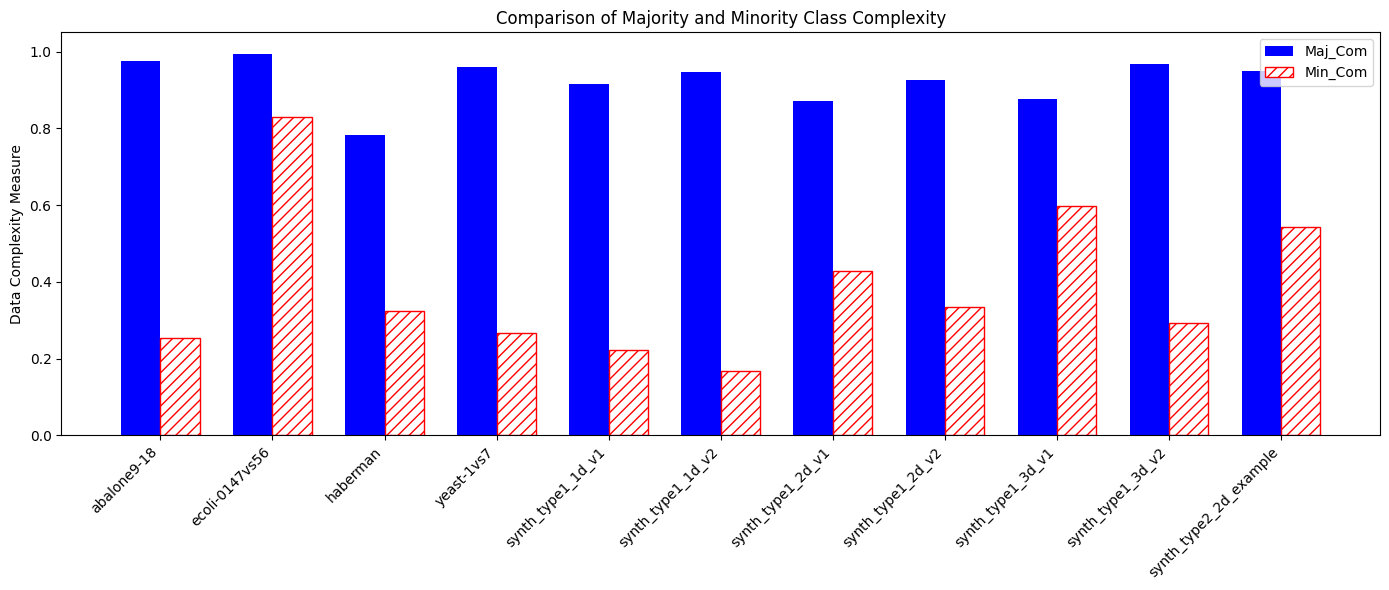

<Figure size 640x480 with 0 Axes>

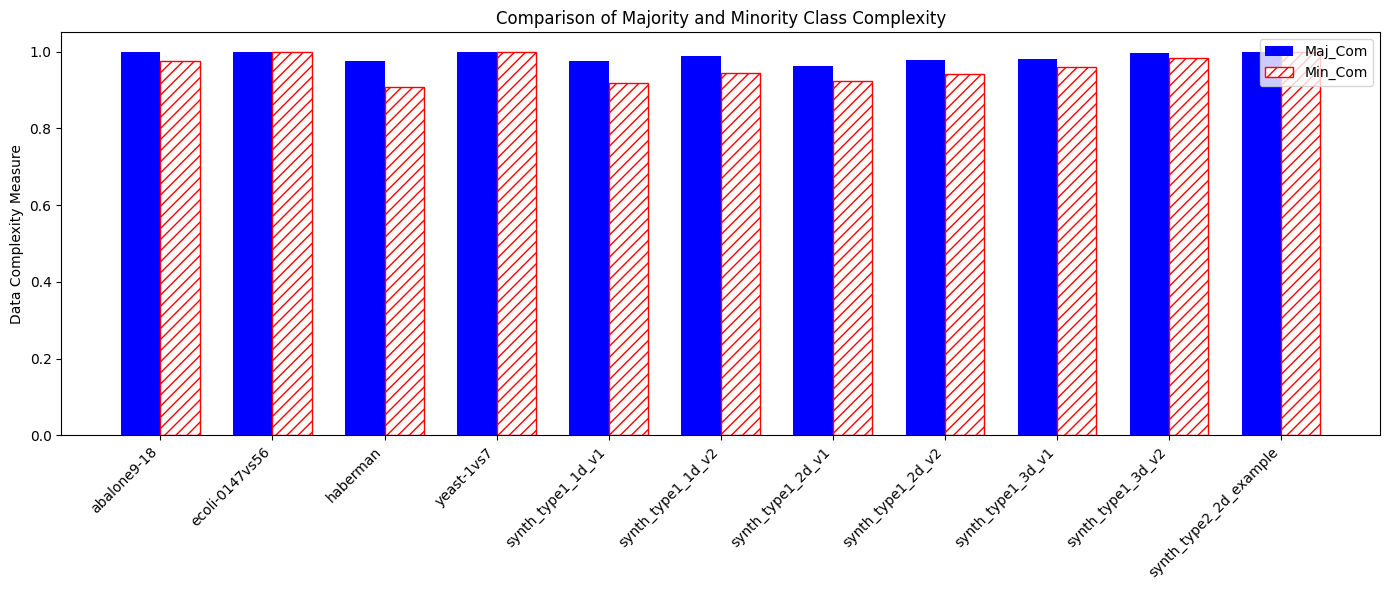

<Figure size 640x480 with 0 Axes>

In [72]:
compare_complexities(datasets)
# I believe that I am having different results because of one-hot encoding for categorical vars
compare_complexities(re_sc_random_weghted_choosing_dataset)

In [73]:
for key, (X, y) in datasets.items():
   if type(X) == pd.DataFrame:
       print(X.dtypes)

Length            float64
Diameter          float64
Height            float64
Whole_weight      float64
Shucked_weight    float64
Viscera_weight    float64
Shell_weight      float64
dtype: object
mcg     float64
gvh     float64
lip     float64
chg     float64
aac     float64
alm1    float64
alm2    float64
dtype: object
Age_of_patient_at_time_of_operation              int64
Patients_year_of_operation                    category
Number_of_positive_axillary_nodes_detected       int64
dtype: object
mcg    float64
gvh    float64
alm    float64
mit    float64
erl    float64
pox    float64
vac    float64
nuc    float64
dtype: object
